# Classificação de diagnóstico do câncer de mama com Deep Neural Network (DNN)

Vamos utilizar o dataset Breast Cacer Wisconsin (Diagnostic) disponível no repositório de datasets da UCI. Este é um conjunto de dados multivariado com atributos numéricos de ponto-flutuante usado para classificação do tipo de câncer de mama de um paciente com MALIGNO ou BENIGNO. O dataset mostra resultados de exames de 699 pacientes coletados entre 1989 e 1991. É composto de 11 atributos que são usados como entrada no modelo:

1. ID do paciente
2. Espesssura (1-10)
3. Uniformidade de tamanho da célula (1-10)
4. Uniformidade de forma da célula (1-10)
5. Adesão marginal (1-10)
6. Tamanho único epitelial da célula (1-10)
7. Quantidade de núcleos nus (1-10)
8. Cromatina (1-10)
9. Quantidade de núcleos normais (1-10)
10. Mitoses (1-10)
11. [SAIDA] Classificação (2 para indicar BENIGNO, 4 para indicar MALIGNO)

O dataset contém 458 amostras com:
- 65.5% de casos BENIGNOS
- 34.5% de casos MALIGNOS

In [155]:
#funcao para deixar o jupyter com celulas preenchendo toda a tela
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [156]:
#importacao de bibliotecas
#exportacao do requiriments.txt
import subprocess
import sys

#bibliotecas para trabalhar com dados e graficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

#bibliotecas do scikit-learn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#biblioteca para exportacoes e importacoes de arquivos
from joblib import dump, load

#utilitario de GPU
from numba import cuda

#biblioteca para implementar uma barra de progresso
import progressbar

#biblioteca para tocar sons
import pygame

#bibliotecas para deep learning
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LayerNormalization, BatchNormalization, Flatten, Dense, Reshape, Dropout

from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import BinaryCrossentropy

#bibliotecas para plotar graficos do keras
import pydot as pyd
import pydotplus
from pydotplus import graphviz
from tensorflow.keras.utils import plot_model, model_to_dot
tensorflow.keras.utils.pydot = pyd

In [157]:
import tensorflow as tf
import keras

print('tensorflow:', tf.__version__)
print('Keras:', keras.__version__)
print("GPU disponivel:", len(tf.config.list_physical_devices('GPU')) > 0)
print('gpu:', tf.config.list_physical_devices('GPU'))

tensorflow: 2.20.0
Keras: 3.12.0
GPU disponivel: False
gpu: []


In [158]:
#Rotina para exportação da lista de pacotes

def exportaRequiriments():
   try:
      resultado = subprocess.run([sys.executable, '-m', 'pip', 'freeze'], capture_output=True, text=True, check=True)
      with open('requiments.txt', 'w') as f:
         f.write(resultado.stdout)
      print(f'Arquivo exportado com sucesso')   
   except subprocess.CalledProcessError as e:
      print(f'Deu erro: {e}')
      
exportaRequiriments()

Arquivo exportado com sucesso


## 2. Importação do dataset

In [159]:
col_names = ['ID', 'espessura', 'tam_celula', 'forma_celula', 'adesao', 'tam_epitelial', 'nucleos_nus', 'cromatina', 'nuclos_normais', 'mitoses', 'diagostico']

data = pd.read_csv('dataset/breast-cancer-wisconsin.csv', header=None, names=col_names)
data = data.drop('ID', axis=1)

#Substitiu '?' por NaN
data = data.replace('?', np.nan)

#converte tudo para numero
data = data.astype(float)

#converte o codigo do diagnostico
data = data.assign(diagnostico=data['diagostico'].replace({2:0, 4:1}))

#nomeia as entradas e saidas
x_names = data.columns[:-2].to_list()
y_names = data.columns[-1:].to_list()

data

,espessura,tam_celula,forma_celula,adesao,tam_epitelial,nucleos_nus,cromatina,nuclos_normais,mitoses,diagostico,diagnostico
0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,2.0,0.0
1,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0,2.0,0.0
2,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,2.0,0.0
3,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,2.0,0.0
4,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
694,3.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,2.0,0.0
695,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,0.0
696,5.0,10.0,10.0,3.0,7.0,3.0,8.0,10.0,2.0,4.0,1.0
697,4.0,8.0,6.0,4.0,3.0,4.0,10.0,6.0,1.0,4.0,1.0


## 3. Configuração do Experimento

In [ ]:
#Realizar interpolação de dados 
interp_exec = True

#Realizar deteccao e substituicao de outliers
outliers_exec = True

#Realizar normalizacao de dados
normalization_exec = True

#Realizar escalonamento de dados
scale_exec = True

#Exportar os datasets tratados
export_frames = False

#Gerar um novo modelo ou usar um pronto
new_model = False


## 4. Análise de Dados

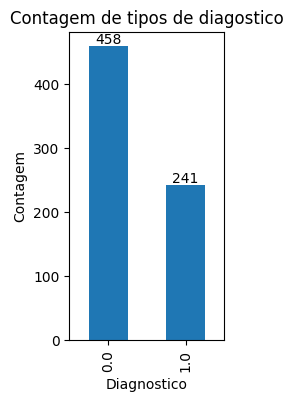

In [161]:
#Contagem de diagonosticos
diag_counts = data['diagnostico'].value_counts()

#Plota grafico de barra
plt.figure(figsize=(2,4))
diag_counts.plot(kind='bar')
plt.xlabel("Diagnostico")
plt.ylabel("Contagem")
plt.title("Contagem de tipos de diagostico")

#adiciona os rotulos
for i, count in enumerate(diag_counts):
   plt.text(i, count, str(count), ha ="center", va="bottom")
   
plt.show()

### 4.1 Sumarização estatística

In [162]:
def sumarizacao(data):
   stats = []
   
   for column in x_names:
      values = data[column]
      maximun = round(values.max(), 2)
      minimun = round(values.min(), 2)
      mean = round(values.mean(), 2)
      median = round(values.median(), 2)
      std = round(values.std(), 2)
      stats.append([column, maximun, minimun, mean, median, std])
      
   headers = ['Coluna', "Máximo", "Mínimo", "Média", "Mediana", "Desvio Padrão"]
   
   table = tabulate(stats, headers, tablefmt='pipe')
   print(table)
   
sumarizacao(data)

| Coluna         |   Máximo |   Mínimo |   Média |   Mediana |   Desvio Padrão |
|:---------------|---------:|---------:|--------:|----------:|----------------:|
| espessura      |       10 |        1 |    4.42 |         4 |            2.82 |
| tam_celula     |       10 |        1 |    3.13 |         1 |            3.05 |
| forma_celula   |       10 |        1 |    3.21 |         1 |            2.97 |
| adesao         |       10 |        1 |    2.81 |         1 |            2.86 |
| tam_epitelial  |       10 |        1 |    3.22 |         2 |            2.21 |
| nucleos_nus    |       10 |        1 |    3.54 |         1 |            3.64 |
| cromatina      |       10 |        1 |    3.44 |         3 |            2.44 |
| nuclos_normais |       10 |        1 |    2.87 |         1 |            3.05 |
| mitoses        |       10 |        1 |    1.59 |         1 |            1.72 |


['espessura', 'tam_celula', 'forma_celula', 'adesao', 'tam_epitelial', 'nucleos_nus', 'cromatina', 'nuclos_normais', 'mitoses']


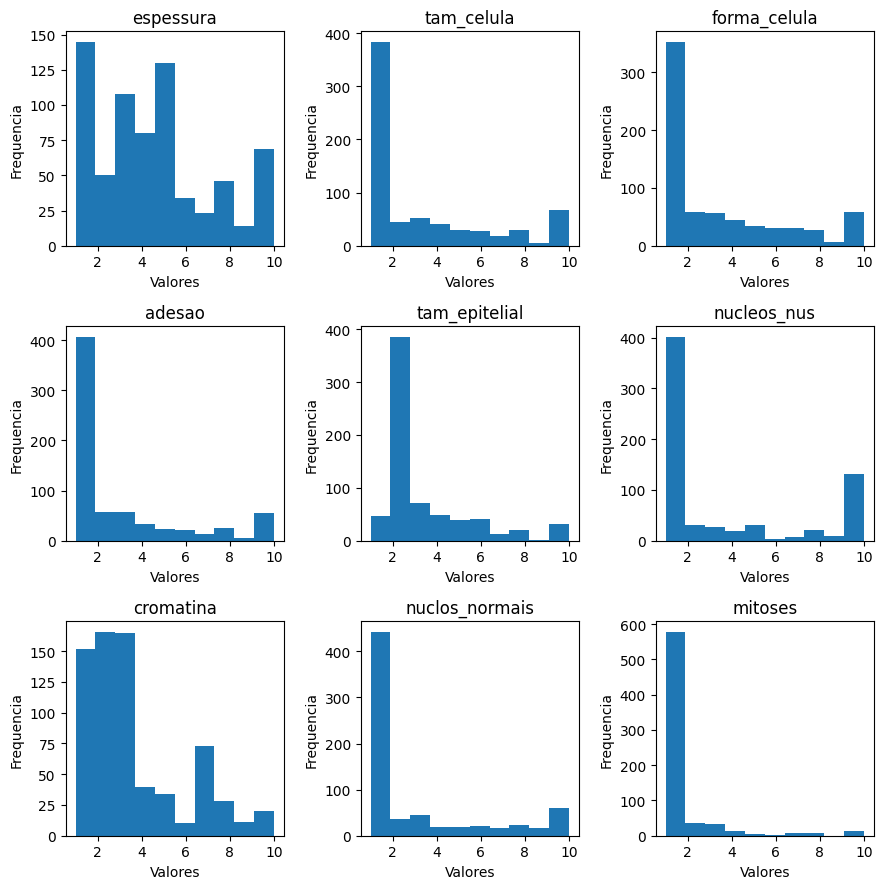

In [163]:
print(x_names)

fig, axs = plt.subplots(3,3, figsize=(9,9), tight_layout=True)

for i, column in enumerate(x_names):
   row = i//3
   col = i%3
   axs[row, col].hist(data[column], bins=10)
   axs[row, col].set_title(column)
   axs[row, col].set_xlabel("Valores")
   axs[row, col].set_ylabel("Frequencia")
   
plt.show()
   

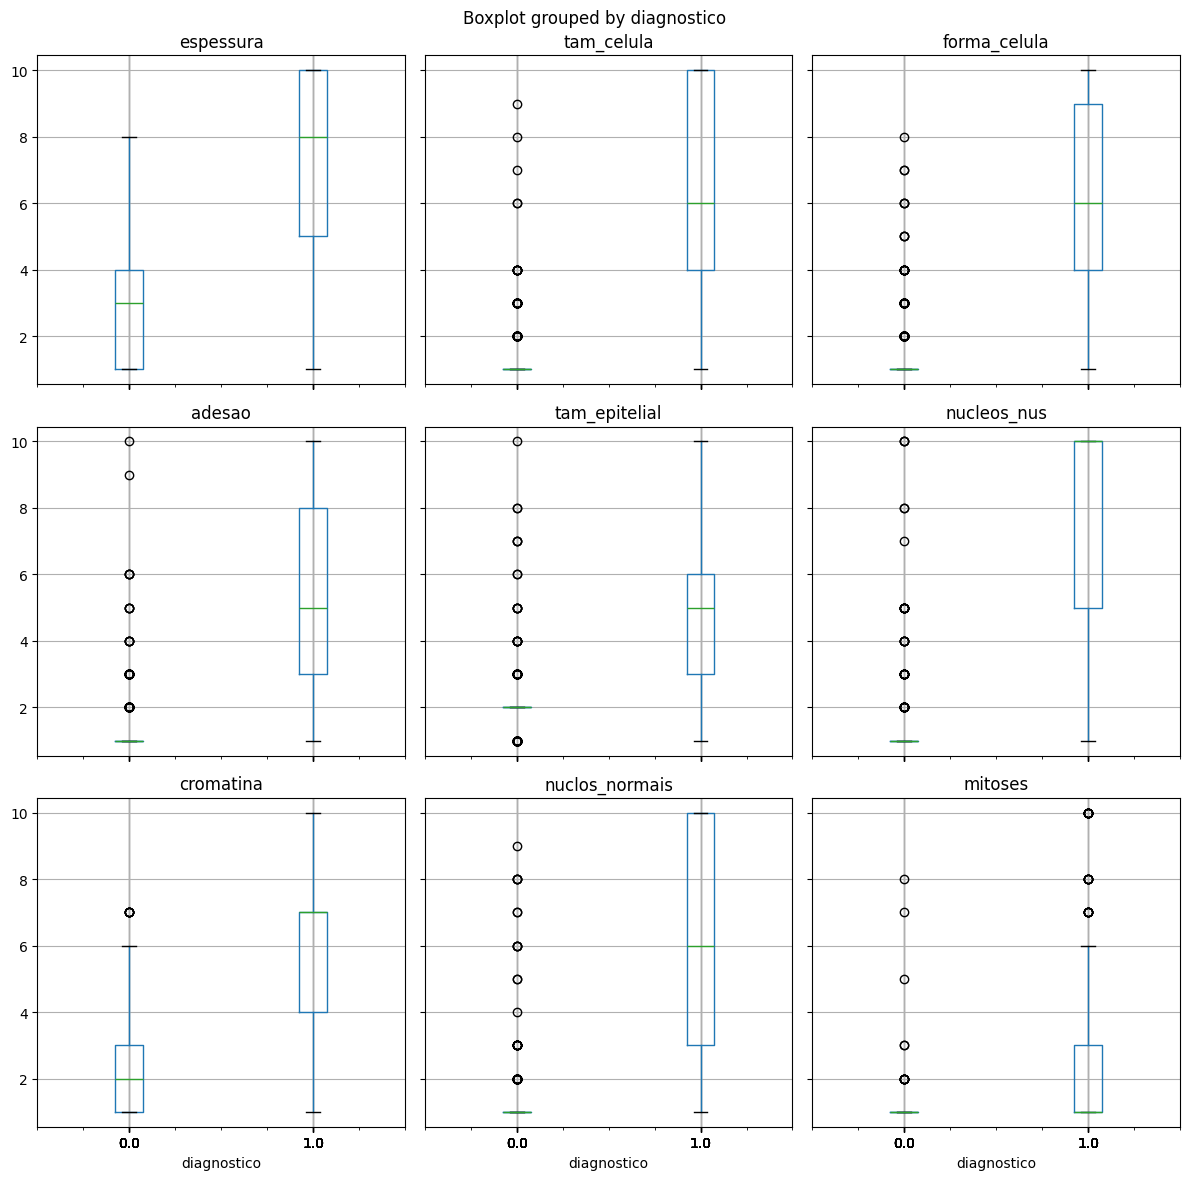

In [164]:
data.boxplot(column=x_names, by='diagnostico', figsize=(12,12))
plt.tight_layout()
plt.show()

### 4.2 Detecçao de Dados Faltantes e Interpolação

In [165]:
misssign_counts = data.isnull().sum()
print('Total de dados faltantes por coluna:', misssign_counts)

Total de dados faltantes por coluna: espessura          0
tam_celula         0
forma_celula       0
adesao             0
tam_epitelial      0
nucleos_nus       16
cromatina          0
nuclos_normais     0
mitoses            0
diagostico         0
diagnostico        0
dtype: int64


In [166]:
#interpola os dados faltantes
def interpolacao(data):
   if data.isnull().values.any():
      points_inds_danger = [0,1, len(data)-2, len(data)-1]
      for colname in x_names:
         for ind_danger in points_inds_danger:
            if np.isnan(data[colname].iloc[ind_danger].astype(float)):
               data[colname].iloc[ind_danger] = data[colname].mean()
         
         data[colname] = data[colname].interpolate(method='nearest').copy()
         
   return data

In [167]:
if interp_exec:
   
   data = interpolacao(data)

   misssign_counts = data.isnull().sum()
   print('Total de dados faltantes por coluna:', misssign_counts)

Total de dados faltantes por coluna: espessura         0
tam_celula        0
forma_celula      0
adesao            0
tam_epitelial     0
nucleos_nus       0
cromatina         0
nuclos_normais    0
mitoses           0
diagostico        0
diagnostico       0
dtype: int64


### 4.3 Detecção e Substituição dos outliers

In [168]:
def getQuantiles(x, margin = 1.5, low = 0.1, high = 0.9):
   q1 = x.quantile(low)
   q3 = x.quantile(high)
   iqr = q3 - q1
   fence_low = q1 - (margin*iqr)
   fence_high = q3 + (margin*iqr)
   
   return [fence_low, fence_high]

def replaceOutliers(serie, m):
   x = serie.copy()
   fences = getQuantiles(x, margin=m)
   bad_ind = x.loc[(x < fences[0]) | (x > fences[1])].index
   x[bad_ind] = np.nan
   
   outlier_inds_danger = [0,1, len(serie)-2, len(serie)-1]
   for ind_danger in outlier_inds_danger:
      if np.isnan(x.iloc[ind_danger]):
         x[ind_danger] = (fences[0] + fences[1])/2
   
   if x.isnull().values.any():
      x = x.interpolate(method='nearest').copy()
      
   return x

In [169]:
if outliers_exec:
   for col in x_names:
      data[col] = replaceOutliers(data[col], 0)

### 4.4 Normalização

In [170]:
def normalization(data, method):
   if method == 'asinh':
      return np.arcsinh(data)
   elif method == 'log':
      return np.log(data)
   else: 
      return (data - np.mean(data))/np.std(data)
   
   

In [171]:
if normalization_exec:
   for col in x_names:
      data[col] = normalization(data[col], 'log')

### 4.5 Escalonamento

In [172]:
def create_support_col(minvalue, maxvalue, sizecol):
   minvalue = [minvalue] * round(sizecol/2)
   maxvalues = [maxvalue] * (sizecol - round(sizecol/2))
   return[*minvalue, *maxvalues]

def minMaxIndividual(df, col, minvalue, maxvalue, rgint):
   #serie = df[col].copy()
   
   #Versão Ciniro
   # # cria uma regua com um valor minimo e maximo previamente determinadao
   # serie['support'] = create_support_col(minvalue, maxvalue, len(serie))
   
   # #escalona considerando o minimo e o maximo especificado
   # tmp = serie.to_numpy().reshape(-1,1)
   
   # #cria o objeto de escalonamento
   # minmaxscaler = preprocessing.MinMaxScaler(feature_range=rgint).fit(tmp)
   
   # #cria os dados escalonados
   # scaled = minmaxscaler.transform(tmp).reshape(serie.shape[0], serie.shape[1])
   
   # #remove a coluna de suporte e atualiza as colunas escalonadas no dataset
   # df[col] = scaled[:, 0:(scaled.shape[1]-1)]
   
   #return df
   
   #Versão Ricardo (muito melhor)
   # valores do intervalo alvo
   a, b = rgint

   # garante 1D
   serie = df[col].to_numpy(dtype=float).reshape(-1)

   #injeta min e max
   extended = np.concatenate([serie, np.array([minvalue, maxvalue], dtype=float)])

   #calcula min e max reais com os pontos injetados
   scaled_extended = a + (extended - minvalue) * (b - a) / (maxvalue - minvalue)

   #remove os valores injetados, mantendo mesmo tamanho que a coluna original
   scaled = scaled_extended[:-2]

   #grava no dataframe
   df.loc[:, col] = scaled

   return df

In [173]:
if scale_exec:
   scale_range = (0, 1)
   for col in x_names:
      data = minMaxIndividual(data, [col], np.min(data[col]), np.max(data[col]), scale_range)

### 4.6 Exportando ou carregando um dataset tratado

In [174]:
if export_frames:
   bar = progressbar.ProgressBar(maxval=len(data), widgets=[progressbar.Bar("=", "[", "]", " ", progressbar.Percentage)])
   bar.start()
   
   x_frames = []
   y_frames = []
   
   cont = 0
   for ind in range(0, len(data)):
      x_frames.append(data.loc[ind, x_names].values)
      y_frames.append(data.loc[ind, y_names].values.reshape(-1))
      
      bar.update(cont + 1)
      cont += 1
   
   x_frames = np.array(x_frames)
   y_frames = np.array(y_frames).reshape(-1,1)
   
   dump(x_frames, 'dataset/x_frames.joblib')
   dump(y_frames, 'dataset/y_frames.joblib')
   
   bar.finish()
   
else: 
   x_frames = load('dataset/x_frames.joblib')
   y_frames = load('dataset/y_frames.joblib')
   
print(x_frames.shape)
print(y_frames.shape)


   

(699, 9)
(699, 1)


In [175]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x_frames, y_frames, test_size=0.3, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, shuffle=True)

print(x_train.shape) 
print(y_train.shape) 
print(x_val.shape) 
print(y_val.shape) 
print(x_test.shape) 
print(y_test.shape) 

(391, 9)
(391, 1)
(98, 9)
(98, 1)
(210, 9)
(210, 1)


## 5. TREINAMENTO DO MODELO

### 5.1 Construção do Modelo

In [176]:
#empilhamento de camadas para construção da stack

#paramentros da rede
act_function = 'sigmoid'
drop = 0.1
initializer = tensorflow.keras.initializers.LecunNormal()

#camada de entrada
inputs = Input(shape=(x_train.shape[1],), dtype = 'float32')

#camada 1
layer1 = Dense(32, activation=act_function, kernel_initializer=initializer)(inputs)
layer1 = Dropout(drop)(layer1)

#camada 2
layer2 = Dense(64, activation=act_function, kernel_initializer=initializer)(layer1)
layer2 = Dropout(drop)(layer2)

#camada 3
layer3 = Dense(32, activation=act_function, kernel_initializer=initializer)(layer2)
layer3 = Dropout(drop)(layer3)

#camada de saida
outputs = Dense(y_train.shape[1], activation=act_function, kernel_initializer=initializer)(layer3)

#geração do modelo
dnn_breast_cancer = Model(inputs, outputs)

### 5.2 Inspeção do modelo

In [177]:
dnn_breast_cancer.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,545 (17.75 KB)

 Trainable params: 4,545 (17.75 KB)

 Non-trainable params: 0 (0.00 B)

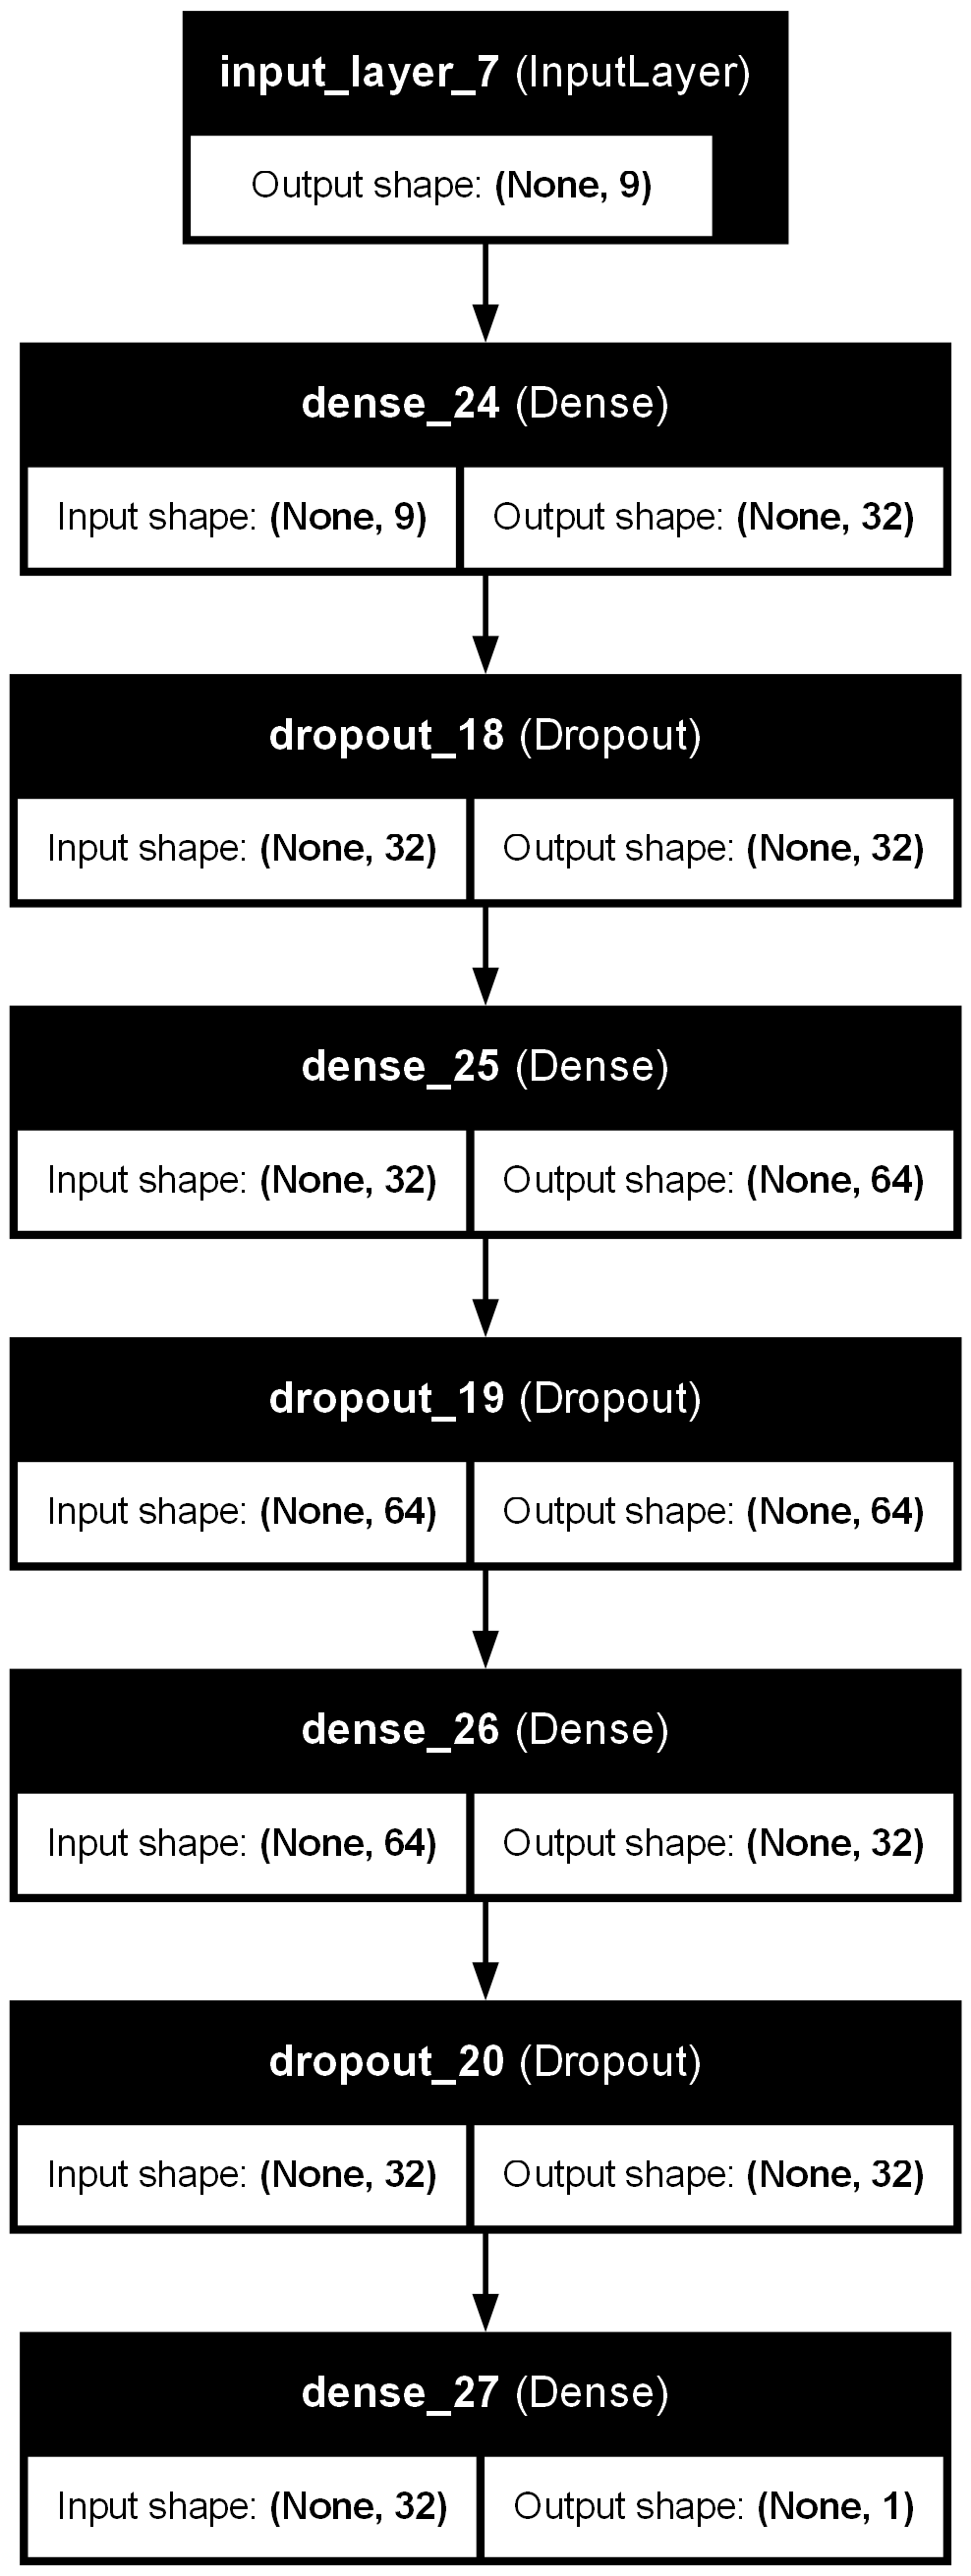

In [178]:
plot_model(dnn_breast_cancer, show_shapes=True, show_layer_names=True, rankdir='TB')

### 5.3 Otimização do modelo

In [179]:
if (new_model):
   tensorflow.keras.backend.set_epsilon(1)
   opt = Adam(learning_rate=0.0001)
   
   dnn_breast_cancer.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
   
   cp = ModelCheckpoint(
      filepath = 'models/best_model.weights.h5',
      save_weights_only = True,
      monitor='loss',
      mode='min',
      save_best_only=True)
   
   es = EarlyStopping(monitor='loss', mode='min', patience=1000)
   
   history = dnn_breast_cancer.fit(
      x_train, y_train, validation_data=(x_val,y_val), epochs=1000, verbose=1, callbacks=[es, cp], batch_size=8, shuffle=False 
   )
   
   np.save('models/history_model.npy', history.history)
   dnn_breast_cancer.load_weights('models/best_model.weights.h5')
   dnn_breast_cancer.save('models/best_model.weights.h5')

else:
   dnn_breast_cancer = load_model('models/best_model.weights.h5')

Epoch 1/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3350 - loss: 0.7758 - val_accuracy: 0.3571 - val_loss: 0.7358
Epoch 2/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3990 - loss: 0.7204 - val_accuracy: 0.3571 - val_loss: 0.6998
Epoch 3/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5064 - loss: 0.6982 - val_accuracy: 0.6429 - val_loss: 0.6772
Epoch 4/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6598 - loss: 0.6649 - val_accuracy: 0.6429 - val_loss: 0.6637
Epoch 5/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6394 - loss: 0.6631 - val_accuracy: 0.6429 - val_loss: 0.6559
Epoch 6/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6573 - loss: 0.6462 - val_accuracy: 0.6429 - val_loss: 0.6516
Epoch 7/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6547 - loss: 0.6567 - val_accuracy: 0.6429 - val_loss: 0.6492
Epoch 8/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6675 - loss: 0.6437 - val_accuracy: 0

In [180]:
pygame.mixer.init()
arquivo_mp3 = 'support_files/mario_coin.mp3'
pygame.mixer.music.load(arquivo_mp3)
pygame.mixer.music.play()

while pygame.mixer.music.get_busy():
   continue

print('SUCESSO!')

SUCESSO!


## 6. Avaliando a Qualidade do Treino

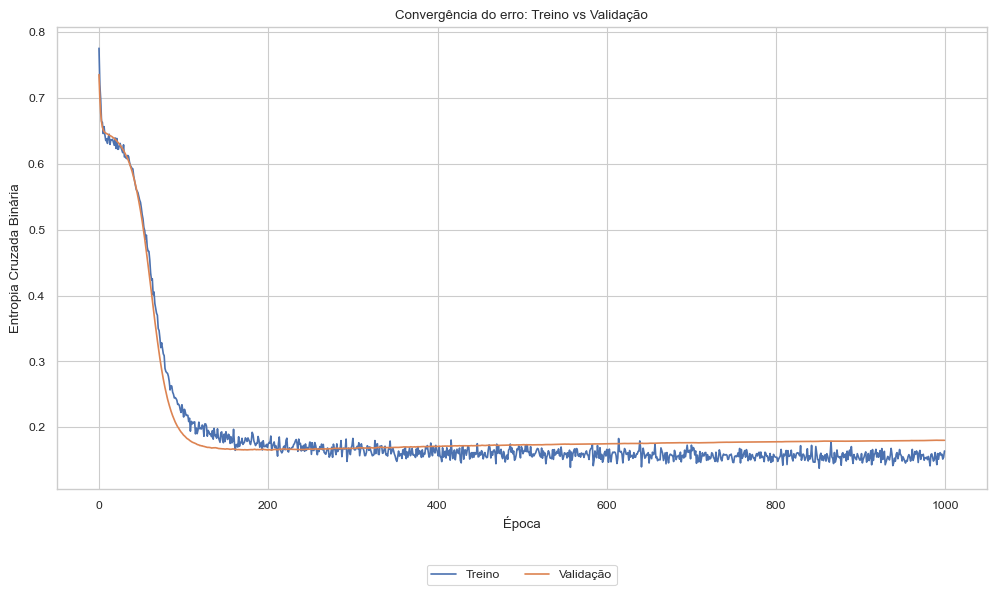

In [185]:
history = np.load('models/history_model.npy', allow_pickle=True).item()

sns.set(rc={'figure.figsize':(12,6)})
sns.set_style('whitegrid')
sns.set_context('paper')

train_metric = history['loss']
valid_metric = history['val_loss']
name_metric = 'Entropia Cruzada Binária'

fig = plt.figure()
plt.plot(train_metric, label='Treino')
plt.plot(valid_metric, label='Validação')
plt.ylabel(name_metric)
plt.xlabel('Época')
plt.title('Convergência do erro: Treino vs Validação')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

## 7. Testando as previsões

### 7.1 Gerando as previsões com o modelo treinado

In [181]:
y_hat = dnn_breast_cancer.predict(x_test)
y_hat, y_test = (y_hat > 0.5, y_test > 0.5)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


### 7.2 Calculando a taxa de acerto com base na matriz de confusão

In [182]:
#calcula a matriz de confusão
cm = confusion_matrix(y_test.tolist(), y_hat.tolist())

#calcula a taxa de acerto (acuracia)
accuracy = (cm[0,0] + cm[1,1]) / cm.sum()
accuracy_percent = round(accuracy*100, 2)
print('Taxa de Acerto: {:.2f}%'.format(accuracy_percent))

Taxa de Acerto: 96.19%


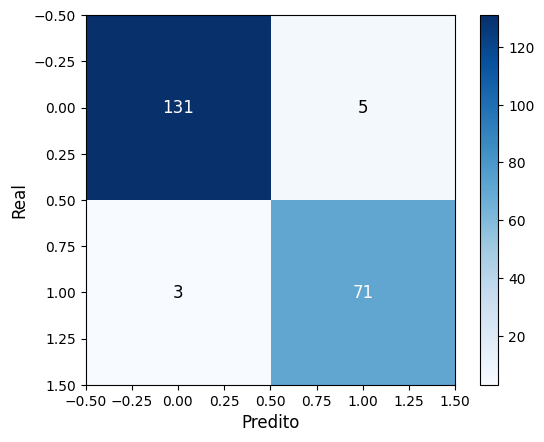

In [184]:
#plot da matriz de confusão
plt.grid(False)
plt.imshow(cm, cmap='Blues')
plt.xlabel('Predito', fontsize = 12)
plt.ylabel('Real', fontsize = 12)

threshold = cm.max()/2
for i in range(cm.shape[0]):
   for j in range(cm.shape[1]):
      color = 'white' if cm[i,j] > threshold else 'black'
      plt.text(j,i,str(cm[i,j]), ha='center', va='center', color=color, fontsize=12)
      
plt.colorbar()
plt.show()

In [186]:
#Teste Final de Classificação
#selecionar pacientes aleatorios e fazer a previsao

#separar indices por diagnosticos
indices_benignos = np.where(y_test == 0)[0]
indices_malignos = np.where(y_test == 1)[0]

#selecionar alguns
idx_benigno = np.random.choice(indices_benignos)
idx_malignos = np.random.choice(indices_malignos)

#fazer previsoes
paciente_benigno = x_test[idx_benigno: idx_benigno+1]
paciente_maligno = x_test[idx_malignos: idx_malignos+1]

#fazer previsoes (y_hat)
pred_benigno = dnn_breast_cancer.predict(paciente_benigno, verbose=0)[0][0]
pred_maligno = dnn_breast_cancer.predict(paciente_maligno, verbose=0)[0][0]

#pega o valor real para comparar com o predito (y_real)
real_benigno = y_test[idx_benigno][0]
real_maligno = y_test[idx_malignos][0]

#classificação
classe_pred_benigno = 'maligno' if pred_benigno > 0.5 else 'benigno'
classe_pred_maligno = 'maligno' if pred_maligno > 0.5 else 'benigno'

#classificação dos previstos
acertou_benigno = (pred_benigno <= 0.5 and real_benigno == 0)
acertou_maligno = (pred_maligno > 0.5 and real_maligno == 1)

#exibir resultado
print('Paciente com Cancer Benigno (real)')
print(f'Probabilidade Prevista: {pred_benigno:.4f}')
print(f'Classificação Prevista: {classe_pred_benigno}')
print(f'Resultado: {"ACERTOU" if acertou_benigno else "Errou"}')

print('Paciente com Cancer Maligno (real)')
print(f'Probabilidade Prevista: {pred_maligno:.4f}')
print(f'Classificação Prevista: {classe_pred_maligno}')
print(f'Resultado: {"ACERTOU" if acertou_maligno else "Errou"}')

Paciente com Cancer Benigno (real)
Probabilidade Prevista: 0.0012
Classificação Prevista: benigno
Resultado: ACERTOU
Paciente com Cancer Maligno (real)
Probabilidade Prevista: 0.9157
Classificação Prevista: maligno
Resultado: ACERTOU
